In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import struct
from types import SimpleNamespace

import const

from pp import *


In [81]:
sim_list = ['enerlow', 'enermed', 'enerhigh']
label_list = [r'$E = 0.1~{\rm MeV}$', r'$E = 1~{\rm MeV}$', r'$E = 10~{\rm MeV}$']
ener_init_list = np.array([1e5, 1e6, 1e7])
nsim = len(sim_list)

data_list = []
for sim_name in sim_list:
    data_path = os.path.join('..', '..', 'scratch', sim_name, 'data')
    _, data = ener_loss_mech(data_path, chunk_size=512, chunk_num=2**12)
    data_list.append(data)


Saved figure as 'ener_mech-062720241413.png'


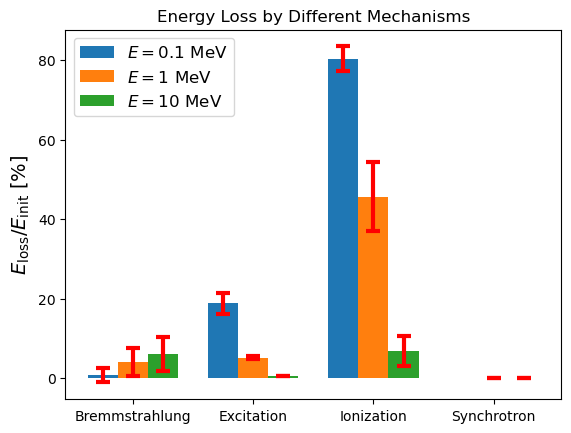

In [84]:
fig, ax = plt.subplots()

width = 1/(nsim+1)

for i, data in enumerate(data_list):
    
    ener_loss_avg = np.mean(data, axis=0)
    ener_loss_std = np.std(data, axis=0)
    
    offset = (i-1)*width
    ax.bar(np.arange(4)+offset, 100*ener_loss_avg/ener_init_list[i], width=width, label=label_list[i])
    ax.errorbar(np.arange(4)+offset, 100*ener_loss_avg/ener_init_list[i], yerr=100*ener_loss_std/ener_init_list[i], color='red', zorder=1, linestyle='', capsize=5, elinewidth=3, capthick=3)

ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(['Bremmstrahlung', 'Excitation', 'Ionization', 'Synchrotron'])
ax.set_ylabel(r'$E_{\rm loss} / E_{\rm init}$ [$\%$]', fontsize=14)
ax.set_title('Energy Loss by Different Mechanisms')
ax.legend(fontsize=12)

save_fig('ener_mech')


In [87]:
sim_list = ['enerlow', 'enermed', 'enerhigh']
label_list = [r'$E = 0.1~{\rm MeV}$', r'$E = 1~{\rm MeV}$', r'$E = 10~{\rm MeV}$']
ener_init_list = np.array([1e5, 1e6, 1e7])
nsim = len(sim_list)

Zelem_bins = np.arange(0.5, 99.5)
Zelem = (Zelem_bins[1:] + Zelem_bins[:-1]) / 2
tsim = 18000

data_list = []
for sim_name in sim_list:
    data_path = os.path.join('..', '..', 'scratch', sim_name, 'data')
    _, data = num_ion(data_path, chunk_size=512, chunk_num=2**12)
    data_list.append(data)


Saved figure as 'nion-062720241415.png'


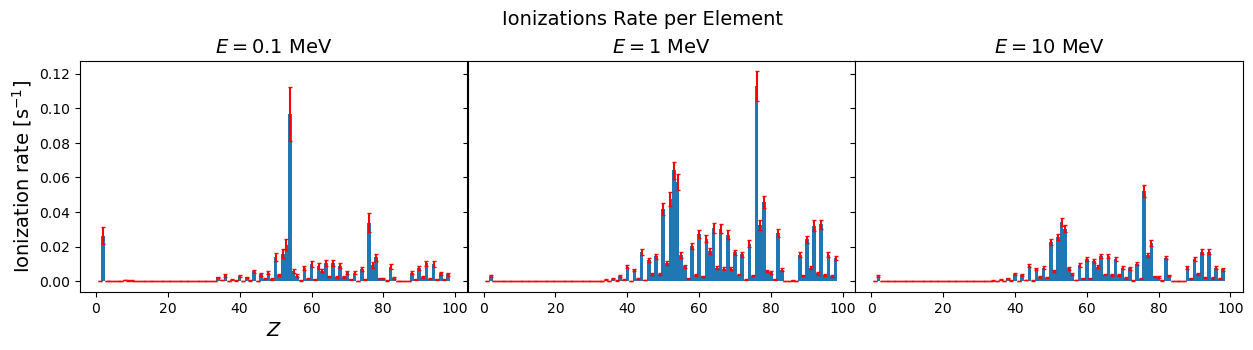

In [89]:
fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(15, 3))
plt.subplots_adjust(wspace=1e-3, hspace=1e-3)

nion_avg = np.mean(data, axis=0)
nion_std = np.std(data, axis=0)

for i, data in enumerate(data_list):
    
    nion_avg = np.mean(data, axis=0)
    nion_std = np.std(data, axis=0)
    
    axs[i].bar(Zelem, nion_avg/tsim, width=1)
    axs[i].errorbar(Zelem, nion_avg/tsim, yerr=nion_std/tsim, color='red', zorder=1, linestyle='', capsize=1.5)
    axs[i].set_title(label_list[i], fontsize=14)

axs[0].set_xlabel(r'$Z$', fontsize=14)
axs[0].set_ylabel(r'Ionization rate [${\rm s^{-1}}$]', fontsize=14)
plt.suptitle('Ionizations Rate per Element', fontsize=14, y=1.05)

save_fig('nion')


In [98]:
num = 64
ener_bins = np.logspace(-1, 5, num)
ener = (ener_bins[1:] + ener_bins[:-1]) / 2
id_list, data = num_sec('../../scratch/enerlow/data', chunk_size=128, chunk_num=2**12, ener_bins=ener_bins)


Text(0.5, 1.0, 'Spectrum of Secondary Electrons Produced by Ionization')

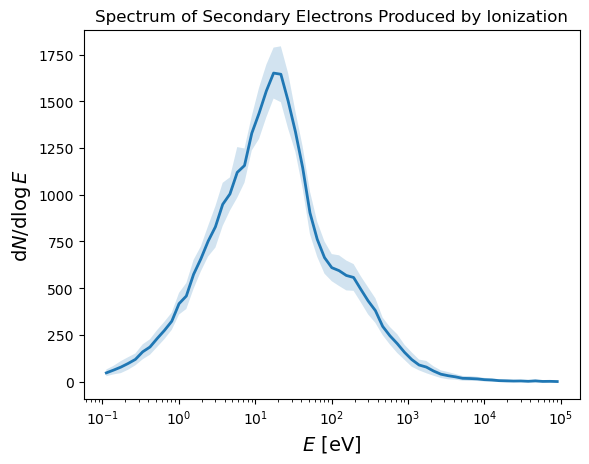

In [100]:
fig, ax = plt.subplots()

nsec_avg = np.mean(data, axis=0)
nsec_std = np.std(data, axis=0)
dlogE = np.log10(ener_bins)[1:] - np.log10(ener_bins)[:-1]

ax.plot(ener, nsec_avg/dlogE, lw=2)
ax.fill_between(ener, (nsec_avg-nsec_std)/dlogE, (nsec_avg+nsec_std)/dlogE, lw=2, alpha=0.2)
ax.set_xscale('log')

ax.set_xlabel(r'$E$ $[{\rm eV}]$', fontsize=14)
ax.set_ylabel(r'${\rm d}N/{\rm d}\log E$', fontsize=14)
ax.set_title('Spectrum of Secondary Electrons Produced by Ionization')

#save_fig('spec_ion')
    

In [137]:
sim_list = ['enerlow', 'enermed', 'enerhigh']
label_list = [r'$E = 0.1~{\rm MeV}$', r'$E = 1~{\rm MeV}$', r'$E = 10~{\rm MeV}$']
ener_init_list = np.array([1e5, 1e6, 1e7])
nsim = len(sim_list)

tmax = 18000
num = 128
time_bins = np.linspace(0, tmax, num)
time = (time_bins[:-1] + time_bins[1:]) / 2

data_list = []
for sim_name in sim_list:
    data_path = os.path.join('..', '..', 'scratch', sim_name, 'data')
    _, data = ener_loss_time(data_path, chunk_size=512, chunk_num=2**14, time_bins=time_bins)
    data_list.append(data)


Saved figure as 'ener_time-062720241425.png'


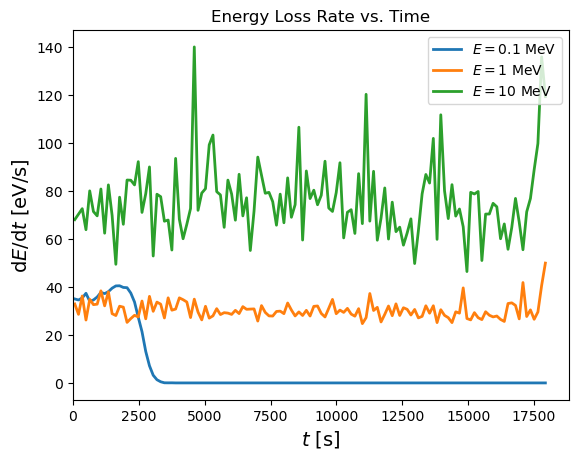

In [138]:
fig, ax = plt.subplots()

for i, data in enumerate(data_list):

    ener_loss_avg = np.mean(data, axis=0)
    ener_loss_std = np.std(data, axis=0)
    dt = time_bins[1:] - time_bins[:-1]
    
    ax.plot(time, ener_loss_avg/dt, lw=2, label=label_list[i])
    #ax.fill_between(time, (ener_loss_avg-ener_loss_std)/dt, (ener_loss_avg+ener_loss_std)/dt, lw=2, alpha=0.2)

ax.set_xlabel(r'$t$ $[{\rm s}]$', fontsize=14)
ax.set_ylabel(r'${\rm d}E/{\rm d}t$ $[{\rm eV/s}]$', fontsize=14)
ax.set_title('Energy Loss Rate vs. Time')
ax.set_xlim(0)
ax.legend(loc=1)

save_fig('ener_time')


In [134]:
sim_list = ['enerlow', 'enermed', 'enerhigh']
label_list = [r'$E = 0.1~{\rm MeV}$', r'$E = 1~{\rm MeV}$', r'$E = 10~{\rm MeV}$']
ener_init_list = np.array([1e5, 1e6, 1e7])
nsim = len(sim_list)

dis_max = 0.05*const.AU
num = 64
dis_bins = np.logspace(np.log10(0.01*const.AU), np.log10(10*const.AU), num)
dis = (dis_bins[1:] + dis_bins[:-1]) / 2

data_list = []
for sim_name in sim_list:
    data_path = os.path.join('..', '..', 'scratch', sim_name, 'data')
    _, data = ener_loss_dis(data_path, chunk_size=512, chunk_num=2**12, dis_bins=dis_bins)
    data_list.append(data)


Saved figure as 'ener_dis-062720241424.png'


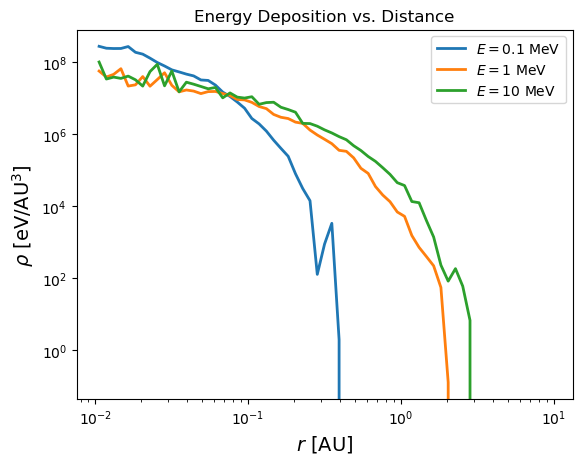

In [136]:
fig, ax = plt.subplots()

for i in range(nsim):
    
    ener_loss_avg = np.mean(data_list[i], axis=0)
    dV = (dis_bins[1:] - dis_bins[:-1]) * 4*np.pi*dis**2
    
    ax.plot(dis/const.AU, ener_loss_avg/dV/(1/const.AU**3), lw=2, label=label_list[i])

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"$r$ [${\rm AU}$]", fontsize=14)
ax.set_ylabel(r"$\rho$ [${\rm eV/AU^3}$]", fontsize=14)
ax.set_title('Energy Deposition vs. Distance')
ax.legend()

save_fig('ener_dis')


Saved figure as 'traj_enerhigh-062720241428.png'


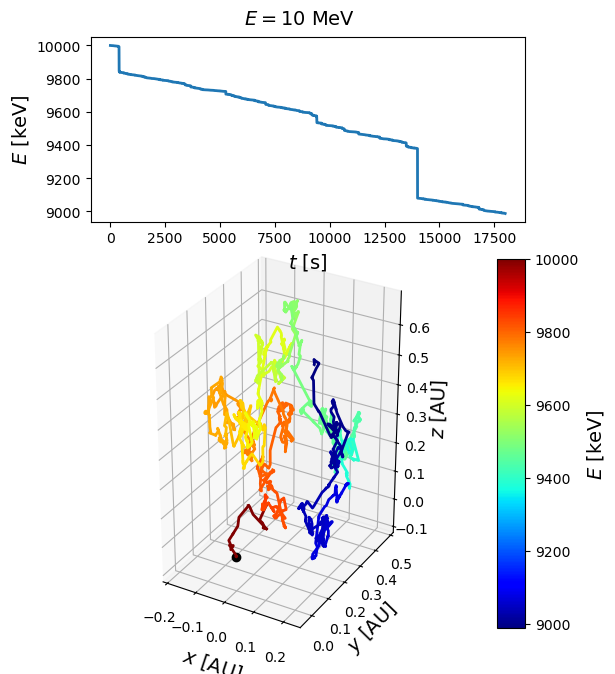

In [156]:
data = read_1part('../../scratch/enerhigh/data', chunk_size=128)

plot_traj(data, var_c=data.ener, unit_c=1e3, cbar_label=r'$E$ [${\rm keV}$]', cval=10000000, do_top=True)
plt.suptitle(r'$E=10~{\rm MeV}$', fontsize=14, y=1.4, x=0.55)

save_fig('traj_enerhigh')
